In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
import random

class PolicyNet(torch.nn.Module):#actor
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)#像是分类问题，输出的是选择每个动作的概率


class ValueNet(torch.nn.Module):#critic
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda#gamma*lmbda是真正的回合间的奖励折扣
        self.epochs = epochs  #训练批次
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):#state是一个四元列表
        state = torch.tensor([state], dtype=torch.float).to(self.device) #形状为(1,4)的二维张量
        probs = self.actor(state)#让演员策略网络根据情况输出动作概率组
        action_dist = torch.distributions.Categorical(probs)#用 probs 构造一个类别分布（Categorical distribution，适用于离散动作）
        action = action_dist.sample()#从这个分布里随机采样一个动作（按概率采样，不是取最大概率）
        return action.item()#把只包含一个数值的张量转换成 Python 标量（比如 int）

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones) #r+γ*V(t+1)
        td_delta = td_target - self.critic(states)#TD误差，r(s,a)+γ*V(st+1)-V(st)
        #评论员网络既要评论本状态的价值，又要评论下个状态的价值
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        #advantage（这里用 GAE 计算得到的）是对未来多个时步的TD误差加权累积,让数据更加平滑,同时优势函数指的是在s状态采取a动作的好坏，正就是好，负就是坏
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        # 计算“旧策略(old policy)对已选动作的对数概率 log π_old(a|s)”，在下面的训练过程中不变
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs) #log( (pΘ'(at|st)/(pΘ(at|st)) )，重要性采样
            surr1 = ratio * advantage #log( (pΘ'(at|st)/(pΘ(at|st)) ) *A（st,at)
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))# 我们希望最大化期望目标J(Θ)，但是pytorch的优化器只能最小化一个损失，所以取负号
            #min 让最终使用的那一项永远是更保守（更小）的 surrogate，遇到好的，不要过于好，遇到坏的，不要过于坏
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))#最小化 MSE(V(s), td_target)，把 td_target 当作“常数目标”来回归
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [3]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500 #总回合数
hidden_dim = 128 #隐藏层大小
gamma = 0.98 #折扣因子γ=gamma*lmbda
lmbda = 0.95 
epochs = 10 #训练批次
eps = 0.2  #PPO中截断范围的参数，设置变化的上限
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

# 全局随机种子（保持）
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
# 给 action_space / observation_space 也设种子（向后兼容）
env.action_space.seed(0)
env.observation_space.seed(0)

state_dim  = env.observation_space.shape[0] #4
action_dim = env.action_space.n #2
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes) #在线策略学习


/home/bian/anaconda3/envs/rl/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 0:   0%|                                                                                                             | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_1133/64045694.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.tensor([state], dtype=torch.float).to(self.device) #形状为(1,4)的二维张量
Iteration 9: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.75it/s, episode=500, return=200.000]


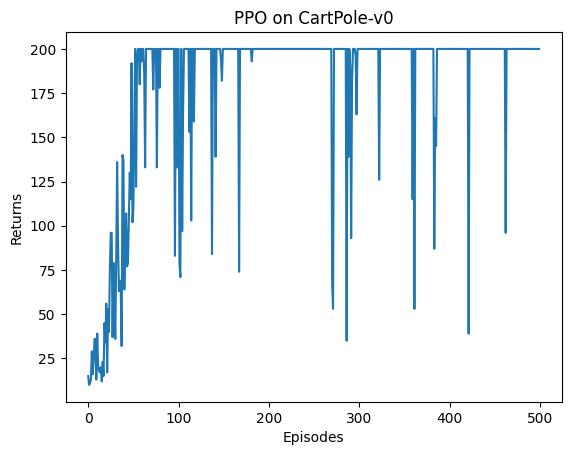

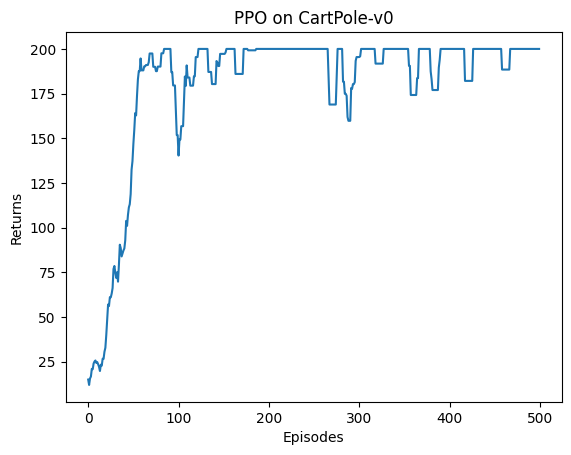

In [4]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
import random
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):#输出动作分布的参数，动作服从高斯（正态）分布
        super(PolicyNetContinuous, self).__init__()#父类torch.nn.Module的初始化
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)#均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)#标准差

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))#限制在【-2，2】
        std = F.softplus(self.fc_std(x))#限制为正
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)#均值，方差
        action_dist = torch.distributions.Normal(mu, sigma)#返回Normal类型的数据
        action = action_dist.sample()#采样一次，得到torch张量
        return [action.item()]#返回一个数字，即要执行的动作

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [7]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
# 全局随机种子（保持）
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
# 给 action_space / observation_space 也设种子（向后兼容）
env.action_space.seed(0)
env.observation_space.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 200/200 [02:15<00:00,  1.47it/s, episode=200,
# return=-984.137]
# Iteration 1: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=400,
# return=-895.332]
# Iteration 2: 100%|██████████| 200/200 [02:14<00:00,  1.48it/s, episode=600,
# return=-518.916]
# Iteration 3: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s, episode=800,
# return=-602.183]
# Iteration 4: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1000,
# return=-392.104]
# Iteration 5: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1200,
# return=-259.206]
# Iteration 6: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1400,
# return=-221.772]
# Iteration 7: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1600,
# return=-293.515]
# Iteration 8: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1800,
# return=-371.194]
# Iteration 9: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=2000,
# return=-248.958]

Iteration 0:   0%|                                                                             | 0/200 [00:00<?, ?it/s]C:\Users\Jaco Bian\AppData\Local\Temp\ipykernel_25180\697691486.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


action_dist Normal(loc: tensor([[-0.3333]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5471]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.8392]], device='cuda:0')
action.item() -0.8392000198364258
action_dist Normal(loc: tensor([[-0.4266]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5505]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.3270]], device='cuda:0')
action.item() -0.3270278573036194
action_dist Normal(loc: tensor([[-0.5409]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5734]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[0.9179]], device='cuda:0')
action.item() 0.917858362197876
action_dist Normal(loc: tensor([[-0.6030]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6110]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.3882]], device='cuda:0')
action.item() -0.38820382952690125
action_dist Normal(loc: tensor([[-0.6320]], device='cu

Iteration 0:   0%|▎                                                                    | 1/200 [00:08<27:50,  8.39s/it]

action_dist Normal(loc: tensor([[-0.3525]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5516]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[0.6077]], device='cuda:0')
action.item() 0.6077119708061218
action_dist Normal(loc: tensor([[-0.4692]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5647]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.3899]], device='cuda:0')
action.item() -0.38991719484329224
action_dist Normal(loc: tensor([[-0.5561]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.5971]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.2688]], device='cuda:0')
action.item() -0.26884374022483826
action_dist Normal(loc: tensor([[-0.5790]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6290]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.0580]], device='cuda:0')
action.item() -0.058038413524627686
action_dist Normal(loc: tensor([[-0.5957]], device

Iteration 0:   1%|▋                                                                    | 2/200 [00:10<14:37,  4.43s/it]

tensor([[-0.7760]], device='cuda:0')
action.item() -0.7759666442871094
action_dist Normal(loc: tensor([[-0.0343]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6540]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.8224]], device='cuda:0')
action.item() -0.8224164247512817
action_dist Normal(loc: tensor([[-0.0812]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6455]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[0.0983]], device='cuda:0')
action.item() 0.0982823297381401
action_dist Normal(loc: tensor([[-0.1533]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6330]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[0.2039]], device='cuda:0')
action.item() 0.20386430621147156
action_dist Normal(loc: tensor([[-0.2328]], device='cuda:0', grad_fn=<MulBackward0>), scale: tensor([[0.6230]], device='cuda:0', grad_fn=<SoftplusBackward0>))
action tensor([[-0.1612]], device='cuda:0')
action.item() -0.1

Iteration 0:   1%|▋                                                                    | 2/200 [00:10<17:18,  5.24s/it]


KeyboardInterrupt: 

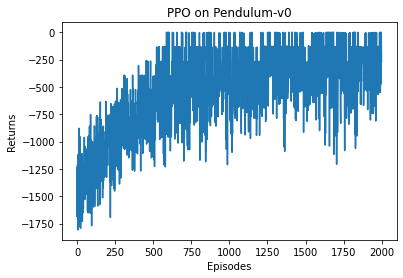

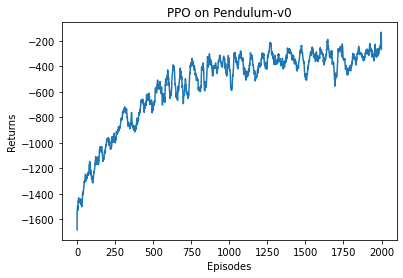

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()